In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import geopandas as gpd
from shapely.geometry import Point
import requests
from PIL import Image
from io import BytesIO
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import random

/Users/mayankagrawal/anaconda3/envs/satellite_ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_excel("../data/raw/train1.xlsx")
df_test = pd.read_excel("../data/raw/test2.xlsx")
df_train.shape

(16209, 21)

In [4]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [5]:
BASE_DIR = Path.cwd().parent        
IMAGE_DIR = BASE_DIR / "data" / "raw" / "images_train"
df_train["image_path"] = df_train["id"].apply(lambda x: IMAGE_DIR / f"{x}.png")

In [6]:
df_train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
image_path       0
dtype: int64

In [7]:
df_train = (df_train.sort_values("date").drop_duplicates(subset="id", keep="last").reset_index(drop=True))
df_train["id"].nunique(),len(df_train)

(16110, 16110)

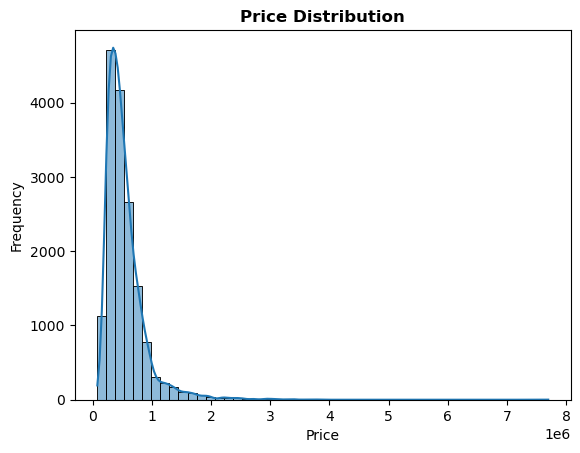

In [8]:
# Lets see the frequency of price distribution
sns.histplot(df_train['price'],bins=50,kde=True)
plt.xlabel('Price')
plt.ylabel("Frequency")
plt.title("Price Distribution",fontweight='bold')
plt.show()

In [9]:
num_cols=['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15']

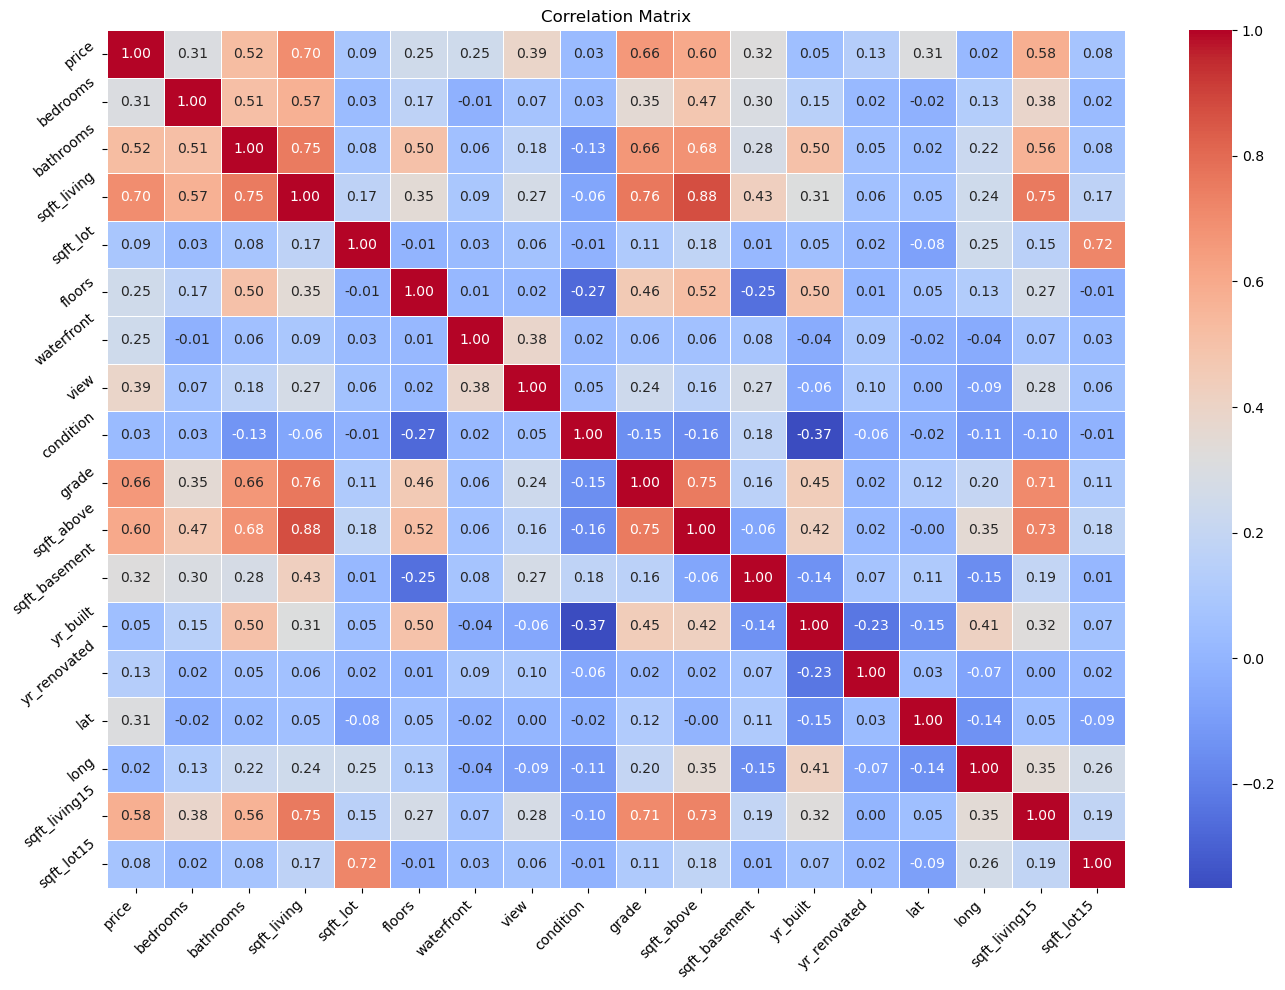

In [10]:
# Lets visualize the correlation between features
plt.figure(figsize=(14,10))
corr_matrix = df_train[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",linewidth=0.5)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=40)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

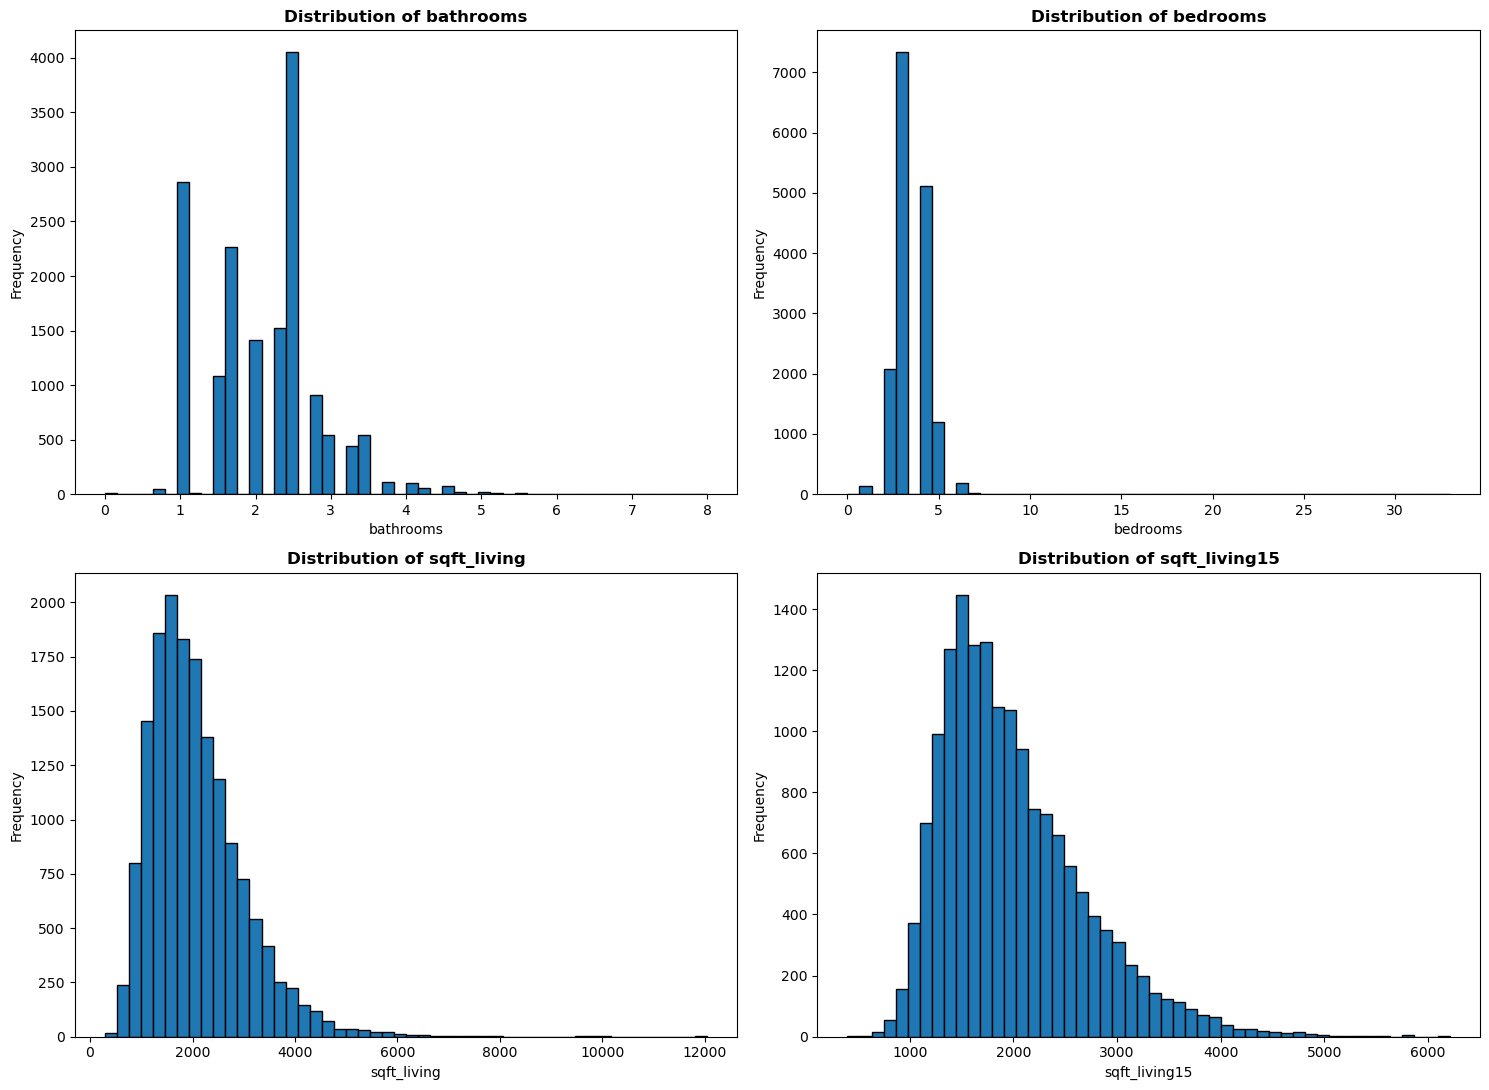

In [11]:
# Lets visualize the distribution of important numerical features
imp_num_features = ['bathrooms','bedrooms','sqft_living','sqft_living15']
plt.figure(figsize=(15,11))

for i,col in enumerate(imp_num_features,1):
    plt.subplot(2,2,i)
    plt.hist(df_train[col],bins=50,edgecolor='black')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}",fontweight='bold')

plt.tight_layout()
plt.show()

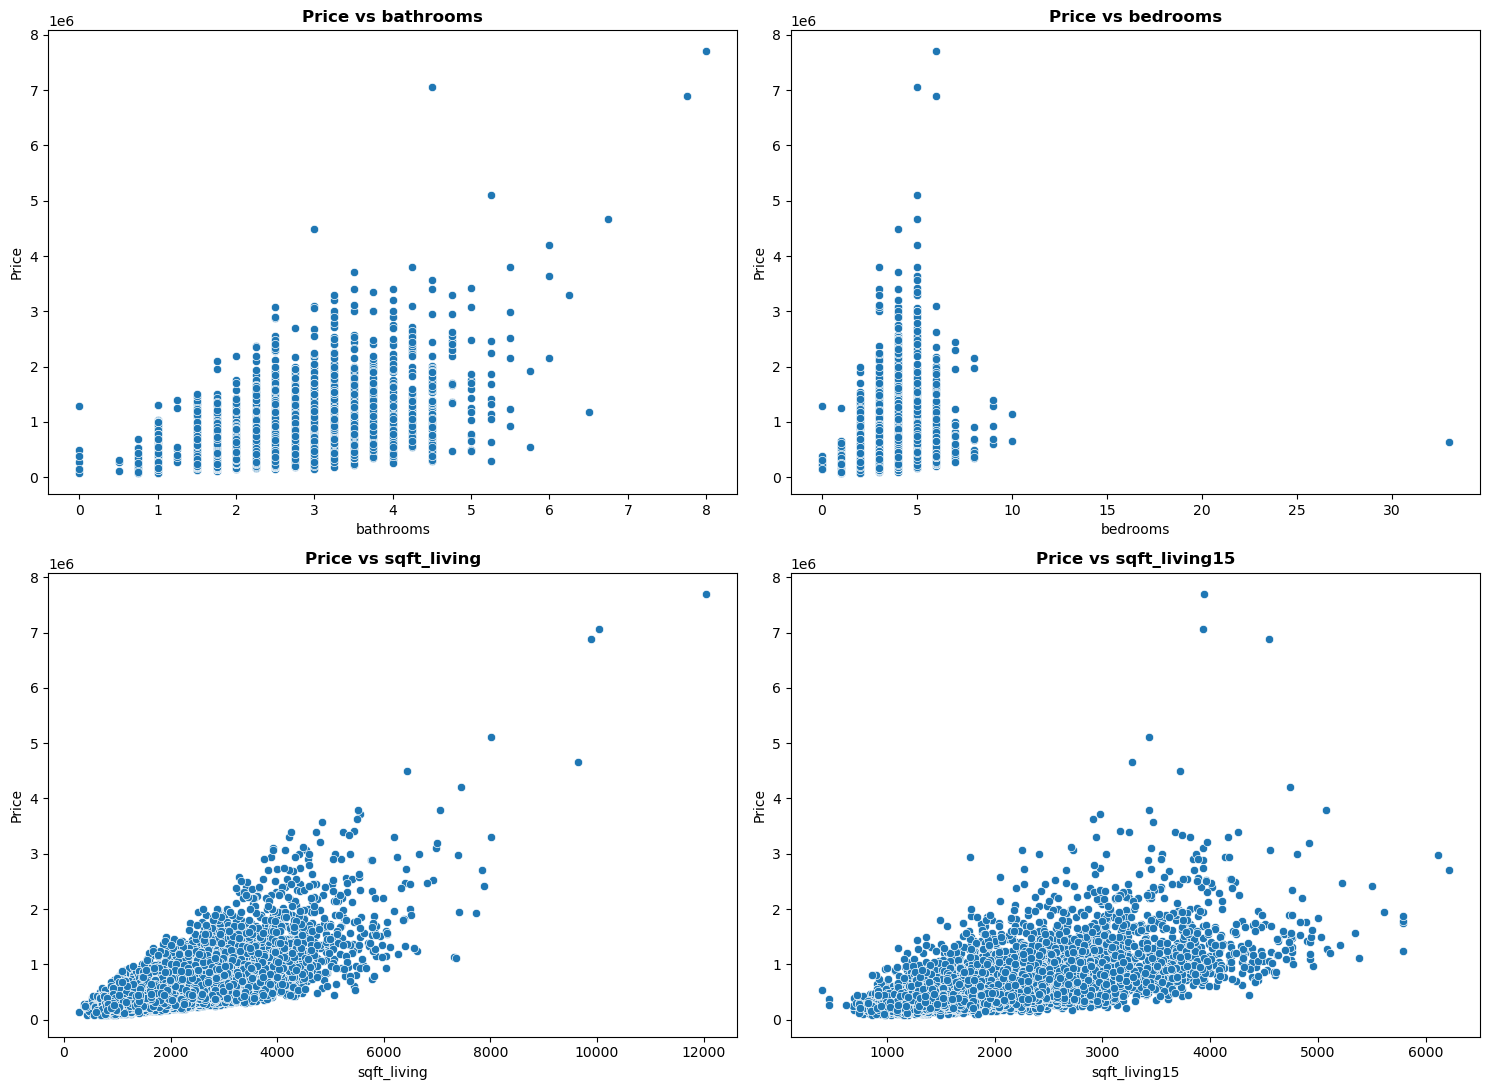

In [12]:
# Lets visualize how these features relate with price
plt.figure(figsize=(15,11))

for i,col in enumerate(imp_num_features,1):
    plt.subplot(2,2,i)
    sns.scatterplot(x=df_train[col],y=df_train['price'])
    plt.xlabel(col)
    plt.ylabel("Price")
    plt.title(f"Price vs {col}",fontweight='bold')

plt.tight_layout()
plt.show()

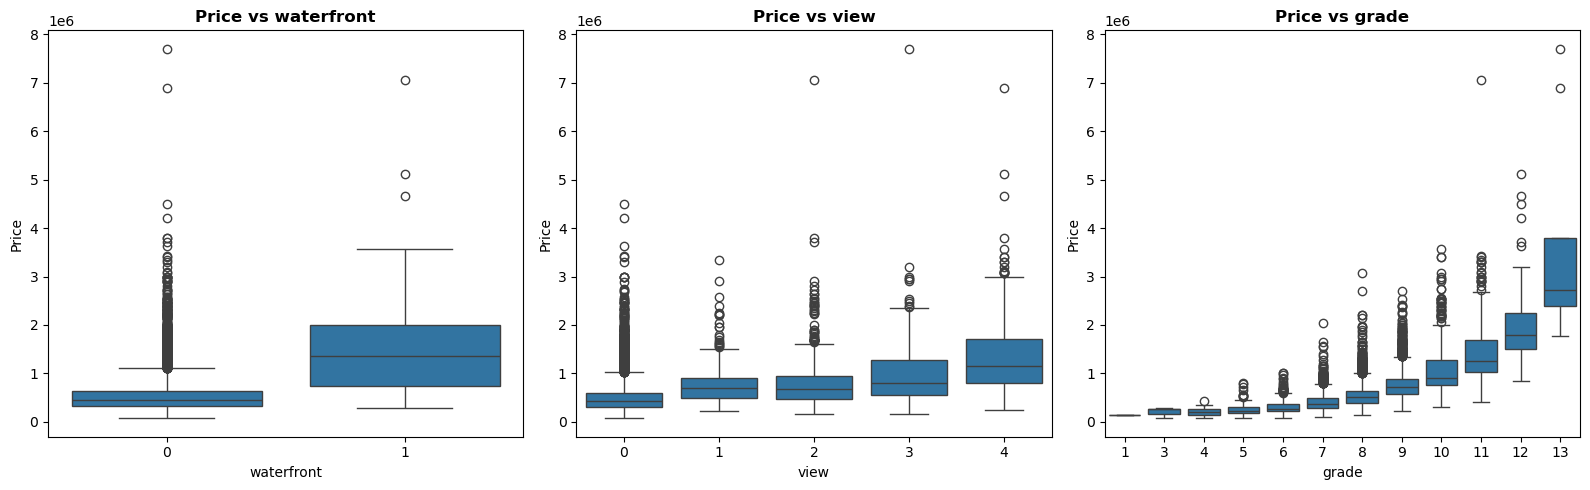

In [13]:
# Lets visualize how important categorical features relates with price
imp_cat_features = ['waterfront','view','grade']
plt.figure(figsize=(16,5))

for i,col in enumerate(imp_cat_features,1):
    plt.subplot(1,3,i)
    sns.boxplot(x=df_train[col],y=df_train['price'])
    plt.xlabel(col)
    plt.ylabel("Price")
    plt.title(f"Price vs {col}",fontweight='bold')

plt.tight_layout()
plt.show()

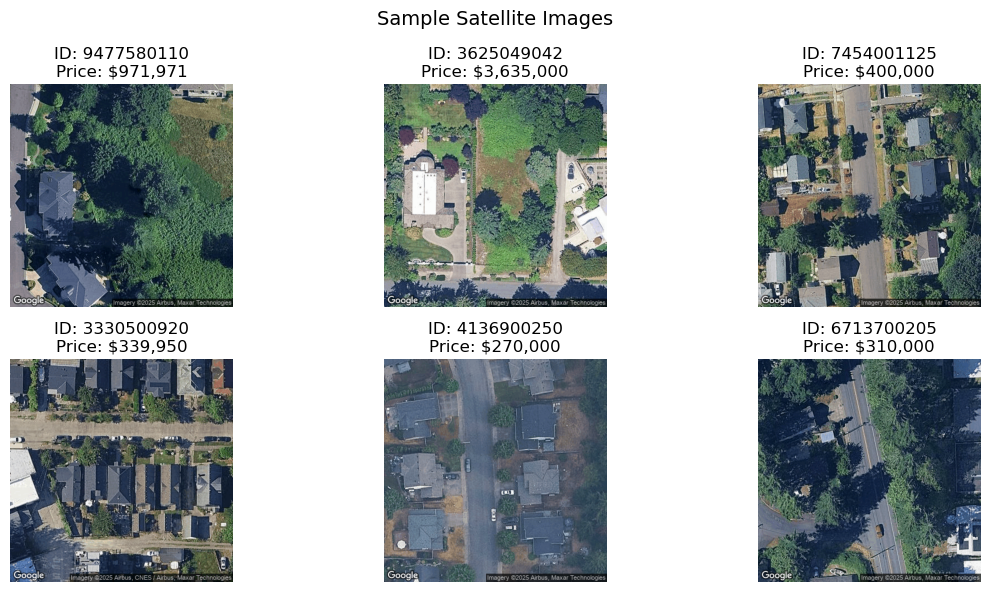

In [22]:
# Lets look at few images we fetched
NUM_SAMPLES = 6

price_map = dict(zip(df_train["id"].astype(str),df_train["price"]))

img_file = random.sample([f for f in os.listdir("../data/raw/images_train") if f.endswith(".png")],NUM_SAMPLES)

plt.figure(figsize=(12, 6))
for i, img_name in enumerate(img_file):
    img_path = os.path.join("../data/raw/images_train", img_name)
    img = Image.open(img_path)

    house_id = img_name.split(".")[0]
    price = price_map.get(house_id,"N/A")

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"ID: {house_id}\nPrice: ${price:,}" if price != "N/A" else f"ID: {house_id}")
    plt.axis("off")

plt.suptitle("Sample Satellite Images", fontsize=14)
plt.tight_layout()
plt.show()

In [16]:
df_train['age'] = 2025 - df_train['yr_built']
target = 'price'
features = ["bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view","condition","grade","sqft_above","sqft_basement","age","lat","long","sqft_living15","sqft_lot15"]

In [17]:
df_train_split , df_val_split = train_test_split(df_train,test_size=0.2,random_state=42)

def split_xy(df,features,target):
    X = df[features].copy()
    y = df[target].copy()
    return X,y

X_train_tab, y_train_tab = split_xy(df_train_split, features, target)
X_val_tab, y_val_tab = split_xy(df_val_split, features, target)

In [18]:
# Scale the data
scaler = StandardScaler()

X_train_scaled_xgb = scaler.fit_transform(X_train_tab)
X_val_scaled_xgb   = scaler.transform(X_val_tab)

In [19]:
joblib.dump(df_train_split,"df_train_split.pkl")
joblib.dump(df_val_split,"df_val_split.pkl")
joblib.dump(X_train_tab,"X_train_tab.pkl")
joblib.dump(X_val_tab,"X_val_tab.pkl")
joblib.dump(y_train_tab,"y_train_tab.pkl")
joblib.dump(y_val_tab,"y_val_tab.pkl")
joblib.dump(scaler,"scaler_xgb.pkl")

['scaler_xgb.pkl']